In [100]:
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
import time

In [101]:
%config Completer.use_jedi = False

In [102]:
class Timer():
    """
    A small class to measure time during training.
    """
    def __init__(self):
        self._start_time = None

    def start(self):
        """
        Start a new timer
        """
        self._start_time = time.perf_counter()

    def stop(self):
        """
        Stop the timer, and report the elapsed time
        """
        if self._start_time is None:
            print(f"Timer is not running. Use .start() to start it")
            return 0
    
        elapsed_time = time.perf_counter() - self._start_time
        self._start_time = None
        
        return elapsed_time

In [106]:
data_models = ['GFDL-ESM4','IPSL-CM6A-LR','MPI-ESM1-2-HR']  # models for temp, prec, LAI
day_len = 30  # for gen_data_card()

dmodel = 'IPSL-CM6A-LR' #np.random.choice(np.array(data_models))  # choose a model
# load all data externally to save computationtime

temp_ds = np.array(xr.open_mfdataset('data/near_surface_air_temperature/historical/{}/*.nc'.format(dmodel)).tas)
prec_ds = np.array(xr.open_mfdataset('data/precipitation_flux/historical/{}/*.nc'.format(dmodel)).pr)
npp_files = glob.glob('data/net_primary_production_on_land/historical/**/*.nc', recursive=True) 
npp_ds = np.array(xr.open_mfdataset(np.random.choice(np.array(npp_files))).npp)
lai_ds = xr.open_mfdataset('data/leaf_area_index/historical/{}/*.nc'.format(dmodel))
lai_ds['lai'] = lai_ds.lai.fillna(0)

# Normalize inputs and outputs
temp_ds = (temp_ds - np.mean(temp_ds)) / np.std(temp_ds)
prec_ds = (prec_ds - np.mean(prec_ds)) / np.std(prec_ds)

npp_ds = np.nan_to_num(npp_ds)
#npp_ds = (npp_ds - np.mean(npp_ds)) / np.std(npp_ds)
#npp_ds = (npp_ds-np.min(npp_ds))/(np.max(npp_ds)-np.min(npp_ds))

#lai_ds["lai"] = (lai_ds.lai - np.min(lai_ds.lai))/(np.max(lai_ds.lai)-np.min(lai_ds.lai))
#lai_ds = (lai_ds - np.mean(lai_ds)) / np.std(lai_ds)

# MinMax outputs
mini = 0
maxi = 6.5
npp_ds = mini+(((npp_ds-np.min(npp_ds))*(maxi-mini))/((np.max(npp_ds)-np.min(npp_ds))))
lai_ds['lai'] = mini+(((lai_ds['lai']-np.min(lai_ds['lai']))*(maxi-mini))/((np.max(lai_ds['lai'])-np.min(lai_ds['lai']))))


max_month = 1978
min_month = day_len//28

def gen_data_card():
    while True:
        
        output_month_i = np.random.randint(min_month, max_month)  # y_pred timepoint in int
        
        try:
            endstamp = lai_ds.indexes['time'].to_datetimeindex()[output_month_i]  # cfttimeindex to datetime
        except:
            endstamp = lai_ds.indexes['time'][output_month_i]
        output_day_i = (endstamp - pd.Timestamp('1850-01-01T12')).days  # output is i-th day in int

        # continue with month-based metrics
        lai = np.array(lai_ds.lai)[output_month_i]

        npp = npp_ds[output_month_i]


        # day-based metrics
        temp = temp_ds[output_day_i-day_len:output_day_i]

        prec = prec_ds[output_day_i-day_len:output_day_i]


        inputs = np.stack((temp,prec), axis=-1)  # two features

        outputs = np.stack((lai,npp), axis=-1)
        
        outputs = np.nan_to_num(outputs)


        yield (inputs, outputs)

In [107]:
"""batch_size = 32
models = ['GFDL-ESM4','IPSL-CM6A-LR','MPI-ESM1-2-HR']  # models for temp, prec, LAI
day_len = 10  # for gen_data_card()

MODEL = 'MPI-ESM1-2-HR'#np.random.choice(np.array(models))
temp_ds = np.array(xr.open_mfdataset('data/near_surface_air_temperature/historical/{}/*.nc'.format(MODEL)).tas)


prec_ds = np.array(xr.open_mfdataset('data/precipitation_flux/historical/{}/*.nc'.format(MODEL)).pr)

# Normalize inputs
temp_ds = (temp_ds - np.mean(temp_ds)) / np.std(temp_ds)
prec_ds = (prec_ds - np.mean(prec_ds)) / np.std(prec_ds)



max_month = 1978

min_month = day_len//32


def gen_data_card():
    while True:
        
        output_month_i = np.random.randint(min_month, max_month)  # y_pred timepoint in int

        # month-based metrics
        
        lai = xr.open_mfdataset('data/leaf_area_index/historical/{}/*.nc'.format(MODEL))

        # compute day index
        try:
            endstamp = lai.indexes['time'].to_datetimeindex()[output_month_i]  # cfttimeindex to datetime
        except:
            endstamp = lai.indexes['time'][output_month_i]
        output_day_i = (endstamp - pd.Timestamp('1850-01-01T12')).days  # output is i-th day in int

        # continue with month-based metrics
        lai = np.array(lai.lai)[output_month_i]
        npp_files = glob.glob('data/net_primary_production_on_land/historical/**/*.nc', recursive=True) 
        npp = xr.open_mfdataset(np.random.choice(np.array(npp_files)))
        npp = np.array(npp.npp)[output_month_i]

        # day-based metrics
        temp = temp_ds[output_day_i-day_len:output_day_i]
        prec = prec_ds[output_day_i-day_len:output_day_i]

        inputs = np.stack((temp,prec), axis=-1)  # two features
        outputs = np.stack((lai,npp), axis=-1)
        outputs = np.nan_to_num(outputs)

        yield (inputs, outputs)"""

"batch_size = 32\nmodels = ['GFDL-ESM4','IPSL-CM6A-LR','MPI-ESM1-2-HR']  # models for temp, prec, LAI\nday_len = 10  # for gen_data_card()\n\nMODEL = 'MPI-ESM1-2-HR'#np.random.choice(np.array(models))\ntemp_ds = np.array(xr.open_mfdataset('data/near_surface_air_temperature/historical/{}/*.nc'.format(MODEL)).tas)\n\n\nprec_ds = np.array(xr.open_mfdataset('data/precipitation_flux/historical/{}/*.nc'.format(MODEL)).pr)\n\n# Normalize inputs\ntemp_ds = (temp_ds - np.mean(temp_ds)) / np.std(temp_ds)\nprec_ds = (prec_ds - np.mean(prec_ds)) / np.std(prec_ds)\n\n\n\nmax_month = 1978\n\nmin_month = day_len//32\n\n\ndef gen_data_card():\n    while True:\n        \n        output_month_i = np.random.randint(min_month, max_month)  # y_pred timepoint in int\n\n        # month-based metrics\n        \n        lai = xr.open_mfdataset('data/leaf_area_index/historical/{}/*.nc'.format(MODEL))\n\n        # compute day index\n        try:\n            endstamp = lai.indexes['time'].to_datetimeindex()[outp

In [108]:
BATCH_SIZE = 16

ds = tf.data.Dataset.from_generator(gen_data_card,output_types = (tf.float32,tf.float32))
train_ds = ds.batch(BATCH_SIZE).take(30).prefetch(tf.data.experimental.AUTOTUNE)

val_ds = ds.batch(BATCH_SIZE).take(30).prefetch(tf.data.experimental.AUTOTUNE)

In [104]:
a = []
for i in train_ds.take(100):
    print(i[0][0])

tf.Tensor(
[[[[-1.403831   -0.39016524]
   [-1.3749101  -0.39016524]
   [-1.3520465  -0.39016524]
   ...
   [-1.4429514  -0.39016524]
   [-1.4479183  -0.39016524]
   [-1.4264181  -0.38550997]]

  [[-0.37434182 -0.37211975]
   [-0.33487928 -0.32736692]
   [-0.26456654 -0.30782795]
   ...
   [-0.6496959  -0.38534665]
   [-0.56143576 -0.39016524]
   [-0.50461596 -0.39016524]]

  [[-0.2605198  -0.2213324 ]
   [-0.2847846  -0.27417102]
   [-0.37350225 -0.29992342]
   ...
   [-0.27517018 -0.29753184]
   [-0.34253946 -0.3340212 ]
   [-0.30177978 -0.30959463]]

  ...

  [[-0.92763424  0.20278619]
   [-0.9058568   0.18334971]
   [-1.0204108   0.25261712]
   ...
   [-1.2662802  -0.09319045]
   [-1.1669133  -0.08774023]
   [-1.0843954  -0.04884184]]

  [[-1.4779724   0.12282215]
   [-1.4853047   0.05757636]
   [-1.4853154   0.12735087]
   ...
   [-1.5641336  -0.00692362]
   [-1.5371641   0.02882738]
   [-1.512451    0.05465257]]

  [[-1.710294   -0.21096501]
   [-1.7180068  -0.24315637]
   [-1.70

tf.Tensor(
[[[[-1.6730273  -0.39016524]
   [-1.6096071  -0.35355723]
   [-1.6047016  -0.36774924]
   ...
   [-1.6453159  -0.3371584 ]
   [-1.6686071  -0.3743618 ]
   [-1.6817772  -0.36238047]]

  [[-0.5441113   0.03028002]
   [-0.56860274 -0.24426557]
   [-0.5940435  -0.34087777]
   ...
   [-0.6328917   0.73372656]
   [-0.56087273  0.46397877]
   [-0.54710037  0.3325471 ]]

  [[-0.4509934   0.07954035]
   [-0.4219064  -0.22290337]
   [-0.3994975  -0.1948894 ]
   ...
   [-0.5341192   0.06949829]
   [-0.60987985 -0.07988337]
   [-0.5618876   0.06223035]]

  ...

  [[-1.0795554  -0.06265562]
   [-1.0929586   0.12563407]
   [-1.261118   -0.23680656]
   ...
   [-1.3392905  -0.39016524]
   [-1.2583691  -0.33847484]
   [-1.1432022  -0.2155919 ]]

  [[-1.4069006  -0.35326737]
   [-1.3637491  -0.33732897]
   [-1.3175458  -0.29888627]
   ...
   [-1.5540595  -0.39016524]
   [-1.5110826  -0.39016524]
   [-1.4702203  -0.39016524]]

  [[-1.5388411  -0.39016524]
   [-1.521816   -0.3797813 ]
   [-1.49

tf.Tensor(
[[[[-2.55032372e+00 -3.90165240e-01]
   [-2.49175787e+00 -3.90165240e-01]
   [-2.52783585e+00 -3.90165240e-01]
   ...
   [-2.65658689e+00 -3.90165240e-01]
   [-2.61141062e+00 -3.90165240e-01]
   [-2.58260226e+00 -3.90165240e-01]]

  [[-1.50856602e+00 -3.90165240e-01]
   [-1.55567026e+00 -3.90165240e-01]
   [-1.65773332e+00 -3.90165240e-01]
   ...
   [-1.74523294e+00 -3.90165240e-01]
   [-1.64350200e+00 -3.32503647e-01]
   [-1.51845908e+00 -3.90165240e-01]]

  [[-1.37722361e+00 -3.26756060e-01]
   [-1.32937324e+00 -3.38407278e-01]
   [-1.31794918e+00 -3.70697528e-01]
   ...
   [-1.40808094e+00 -2.01731116e-01]
   [-1.77963531e+00 -3.19230527e-01]
   [-1.62178016e+00 -3.19379985e-01]]

  ...

  [[-2.11120695e-01 -2.21045509e-01]
   [-1.89049602e-01  8.08373913e-02]
   [-1.80112273e-01  1.34447787e-03]
   ...
   [-2.72029996e-01 -3.90165240e-01]
   [-2.64942855e-01 -3.63220364e-01]
   [-2.78070897e-01 -3.32045197e-01]]

  [[-2.00266182e-01 -1.96690097e-01]
   [-1.99986801e-01 -

tf.Tensor(
[[[[-2.3958597e+00 -3.9016524e-01]
   [-2.3203328e+00 -3.8480502e-01]
   [-2.3516257e+00 -3.9016524e-01]
   ...
   [-2.6085119e+00 -3.9016524e-01]
   [-2.5199583e+00 -3.9016524e-01]
   [-2.4864695e+00 -3.9016524e-01]]

  [[-1.3269992e+00 -3.7660971e-01]
   [-1.4175178e+00 -3.6777037e-01]
   [-1.4717612e+00 -3.9016524e-01]
   ...
   [-1.4703914e+00 -3.9016524e-01]
   [-1.4504734e+00 -3.9016524e-01]
   [-1.3644426e+00 -3.9016524e-01]]

  [[-1.3156999e+00 -3.9016524e-01]
   [-1.3760304e+00 -3.8374901e-01]
   [-1.3413588e+00 -3.5924864e-01]
   ...
   [-1.1433184e+00 -3.9016524e-01]
   [-1.4398932e+00 -2.8702611e-01]
   [-1.4260383e+00 -3.5645694e-01]]

  ...

  [[-1.1993678e+00 -3.9016524e-01]
   [-1.1289196e+00 -3.5316691e-01]
   [-1.1182959e+00 -3.6421514e-01]
   ...
   [-1.3886853e+00 -3.9016524e-01]
   [-1.3414201e+00 -3.9016524e-01]
   [-1.2511315e+00 -3.9016524e-01]]

  [[-1.3843948e+00 -3.9016524e-01]
   [-1.3892562e+00 -3.8531592e-01]
   [-1.4536549e+00 -3.9016524e-01]
 

tf.Tensor(
[[[[-1.98711264e+00 -3.90165240e-01]
   [-1.96452916e+00 -3.85314226e-01]
   [-1.96029854e+00 -3.90165240e-01]
   ...
   [-2.09219337e+00 -3.90165240e-01]
   [-2.06918931e+00 -3.90165240e-01]
   [-2.04353833e+00 -3.90165240e-01]]

  [[-7.65760124e-01 -3.21467042e-01]
   [-7.52171636e-01 -3.35602134e-01]
   [-7.66393006e-01 -3.59904736e-01]
   ...
   [-1.05454433e+00 -3.90165240e-01]
   [-9.54464734e-01 -3.90165240e-01]
   [-8.18537414e-01 -3.90165240e-01]]

  [[-5.09470940e-01 -3.38669568e-01]
   [-5.00010490e-01 -9.38714296e-02]
   [-5.79773724e-01 -3.50187749e-01]
   ...
   [-5.85043430e-01 -2.64031023e-01]
   [-6.71925187e-01 -2.99423814e-01]
   [-5.78961194e-01 -3.90165240e-01]]

  ...

  [[-1.20908332e+00 -1.87834308e-01]
   [-1.18040407e+00 -2.24196896e-01]
   [-1.15665376e+00 -2.51387089e-01]
   ...
   [-1.46302414e+00 -3.90165240e-01]
   [-1.37753856e+00 -3.69058639e-01]
   [-1.27756155e+00 -3.06455791e-01]]

  [[-1.41369343e+00 -1.45004988e-01]
   [-1.32634699e+00  

tf.Tensor(
[[[[-1.6189615  -0.39016524]
   [-1.5906805  -0.39016524]
   [-1.5687256  -0.39016524]
   ...
   [-1.6690433  -0.39016524]
   [-1.6609027  -0.39016524]
   [-1.6293961  -0.39016524]]

  [[-0.6055167  -0.39016524]
   [-0.58152837 -0.39016524]
   [-0.5929331  -0.39016524]
   ...
   [-0.8867249  -0.3788414 ]
   [-0.72681355 -0.39016524]
   [-0.68110627 -0.39016524]]

  [[-0.3304263   0.95021546]
   [-0.32228148  1.3568617 ]
   [-0.318889    1.4699765 ]
   ...
   [-0.46145305 -0.39016524]
   [-0.44961643  0.10807011]
   [-0.39273536  0.6222337 ]]

  ...

  [[-0.9702897   0.42919737]
   [-0.8747101   0.08708228]
   [-0.95240647 -0.3169589 ]
   ...
   [-1.8175677  -0.39016524]
   [-1.6473962  -0.32480127]
   [-1.3135012  -0.04663513]]

  [[-1.0397729   0.06733424]
   [-1.0307221  -0.21803077]
   [-1.0119417  -0.39016524]
   ...
   [-1.3054655  -0.35317716]
   [-1.1634173  -0.24702393]
   [-1.0621846   0.03626766]]

  [[-1.4308283   0.23356043]
   [-1.4372911   0.2085894 ]
   [-1.44

tf.Tensor(
[[[[-3.120771   -0.39016524]
   [-2.9958344  -0.39016524]
   [-2.892048   -0.39016524]
   ...
   [-3.3381734  -0.39016524]
   [-3.1865838  -0.39016524]
   [-3.1599677  -0.39016524]]

  [[-2.2900314  -0.39016524]
   [-2.21077    -0.39016524]
   [-2.2245758  -0.39016524]
   ...
   [-2.193607   -0.39016524]
   [-2.349027   -0.39016524]
   [-2.3668668  -0.39016524]]

  [[-1.010797    0.35696006]
   [-1.1391625  -0.00963235]
   [-1.2596605  -0.2771454 ]
   ...
   [-1.4946754   0.03346244]
   [-1.4179049   1.2274759 ]
   [-1.1922506   0.8415101 ]]

  ...

  [[-0.17941383 -0.31395552]
   [-0.17889069 -0.06520879]
   [-0.1804059  -0.01800578]
   ...
   [-0.18965968 -0.3405951 ]
   [-0.18587664 -0.34516802]
   [-0.18177858 -0.34948778]]

  [[-0.31996375 -0.35314122]
   [-0.31146544 -0.35422617]
   [-0.3113172  -0.3545546 ]
   ...
   [-0.31390148 -0.36109954]
   [-0.29697898 -0.35970432]
   [-0.3098861  -0.37156302]]

  [[-0.26643527 -0.39016524]
   [-0.256875   -0.35204104]
   [-0.23

tf.Tensor(
[[[[-1.7834469  -0.3142914 ]
   [-1.7357376  -0.30024493]
   [-1.6889505  -0.2968418 ]
   ...
   [-1.9520147  -0.39016524]
   [-1.9219534  -0.39016524]
   [-1.8981905  -0.39016524]]

  [[-1.7196056  -0.39016524]
   [-1.6920815  -0.39016524]
   [-1.6782779  -0.39016524]
   ...
   [-1.3735232  -0.36183825]
   [-1.4764665  -0.39016524]
   [-1.6618863  -0.39016524]]

  [[-1.2203156  -0.39016524]
   [-1.1842598  -0.39016524]
   [-1.1439776  -0.39016524]
   ...
   [-1.0547924  -0.39016524]
   [-1.2979286  -0.39016524]
   [-1.3217871  -0.39016524]]

  ...

  [[-0.9662358  -0.36513102]
   [-0.96035886 -0.34469756]
   [-0.96175003 -0.34573963]
   ...
   [-1.1646852  -0.35430902]
   [-1.1083808  -0.35290372]
   [-1.045704   -0.3519443 ]]

  [[-0.93829346 -0.28122035]
   [-0.9548154  -0.28089812]
   [-0.9247064  -0.30463126]
   ...
   [-0.9351048  -0.2983431 ]
   [-0.9340443  -0.25214142]
   [-0.9263314  -0.26918057]]

  [[-0.697604   -0.2918132 ]
   [-0.6895091  -0.3050196 ]
   [-0.69

tf.Tensor(
[[[[-2.3471825  -0.25935316]
   [-2.34732    -0.29814604]
   [-2.450443   -0.39016524]
   ...
   [-2.6414254  -0.39016524]
   [-2.5198443  -0.39016524]
   [-2.3904068  -0.32225052]]

  [[-0.7994469  -0.1817999 ]
   [-0.80757886 -0.19137017]
   [-0.9484538  -0.35158634]
   ...
   [-1.1736383  -0.10570864]
   [-0.8673165   0.04443332]
   [-0.78122014  0.2762089 ]]

  [[-0.7984149  -0.17432289]
   [-0.7496444  -0.21000107]
   [-0.74947333 -0.25895083]
   ...
   [-0.95282125 -0.35910007]
   [-0.8904395  -0.24972455]
   [-0.92448974 -0.34474516]]

  ...

  [[-0.49352768 -0.33548862]
   [-0.49344644 -0.2905269 ]
   [-0.4848441  -0.28978154]
   ...
   [-0.4265048  -0.326907  ]
   [-0.44324484 -0.32888365]
   [-0.48134896 -0.3428978 ]]

  [[-0.51433015 -0.28109324]
   [-0.5150129  -0.2632191 ]
   [-0.5089692  -0.27962533]
   ...
   [-0.55528224 -0.19366778]
   [-0.5201045  -0.24061735]
   [-0.5269636  -0.24235097]]

  [[-0.8371576  -0.30886588]
   [-0.8428008  -0.29526588]
   [-0.84

tf.Tensor(
[[[[-1.3535032  -0.39016524]
   [-1.3089007  -0.39016524]
   [-1.2909846  -0.39016524]
   ...
   [-1.4007329  -0.35266626]
   [-1.4031945  -0.39016524]
   [-1.3986169  -0.37127608]]

  [[-0.47357336 -0.39016524]
   [-0.49916947 -0.39016524]
   [-0.50486255 -0.39016524]
   ...
   [-0.48182505 -0.39016524]
   [-0.40234834 -0.20097229]
   [-0.46361968 -0.39016524]]

  [[-0.28294152 -0.05334355]
   [-0.25898746 -0.17723517]
   [-0.24058254 -0.22445673]
   ...
   [-0.4233247  -0.39016524]
   [-0.44902918 -0.31392652]
   [-0.36287153 -0.16238536]]

  ...

  [[-1.2071306  -0.39016524]
   [-1.2202393  -0.39016524]
   [-1.2798387  -0.39016524]
   ...
   [-1.2102479  -0.35480946]
   [-1.214678   -0.39016524]
   [-1.1889436  -0.36907974]]

  [[-1.3803751  -0.35969958]
   [-1.4090481  -0.39016524]
   [-1.4754145  -0.39016524]
   ...
   [-1.3020922  -0.24193989]
   [-1.3244997  -0.2716965 ]
   [-1.3414571  -0.33191258]]

  [[-1.6520823  -0.39016524]
   [-1.6486306  -0.39016524]
   [-1.64

tf.Tensor(
[[[[-2.0073869e+00 -2.9633188e-01]
   [-1.9066154e+00 -2.2168490e-01]
   [-1.8799167e+00 -2.2532392e-01]
   ...
   [-2.0972195e+00 -3.6039904e-01]
   [-2.0906711e+00 -3.7528956e-01]
   [-2.0777874e+00 -3.4763050e-01]]

  [[-1.4470124e+00 -3.9016524e-01]
   [-1.5046861e+00 -3.9016524e-01]
   [-1.5842746e+00 -3.9016524e-01]
   ...
   [-1.4427519e+00 -3.9016524e-01]
   [-1.4270018e+00 -3.4011161e-01]
   [-1.4201157e+00 -3.4540164e-01]]

  [[-1.3320245e+00 -3.0407032e-01]
   [-1.4059228e+00 -3.0480850e-01]
   [-1.4220877e+00 -2.7894229e-01]
   ...
   [-1.1188297e+00 -3.9016524e-01]
   [-1.3647355e+00 -3.9016524e-01]
   [-1.3700595e+00 -3.7231168e-01]]

  ...

  [[-1.0935230e+00 -3.9016524e-01]
   [-1.0515845e+00 -3.9016524e-01]
   [-1.0115882e+00 -3.9016524e-01]
   ...
   [-1.1302395e+00 -3.1764212e-01]
   [-1.1178926e+00 -3.4142053e-01]
   [-1.0889816e+00 -3.9016524e-01]]

  [[-1.0652314e+00 -3.9016524e-01]
   [-1.0534118e+00 -3.9016524e-01]
   [-1.0456512e+00 -3.9016524e-01]
 

tf.Tensor(
[[[[-2.225336   -0.39016524]
   [-2.1798768  -0.39016524]
   [-2.1500144  -0.39016524]
   ...
   [-2.414512   -0.39016524]
   [-2.3539248  -0.39016524]
   [-2.269894   -0.39016524]]

  [[-1.1443205  -0.39016524]
   [-1.1913712  -0.39016524]
   [-1.2794759  -0.39016524]
   ...
   [-1.2500682  -0.39016524]
   [-1.1669538  -0.39016524]
   [-1.1243454  -0.39016524]]

  [[-0.96256536 -0.3591451 ]
   [-0.9352274  -0.39016524]
   [-0.95191896 -0.39016524]
   ...
   [-1.0414199  -0.38036427]
   [-1.2364898  -0.39016524]
   [-1.1690185  -0.36820626]]

  ...

  [[-0.9739316  -0.39016524]
   [-1.0425346  -0.39016524]
   [-1.0922372  -0.39016524]
   ...
   [-0.7602851  -0.37379113]
   [-0.8497568  -0.39016524]
   [-0.9286477  -0.39016524]]

  [[-1.0645928  -0.2871451 ]
   [-1.087517   -0.30689687]
   [-1.1322465  -0.28663355]
   ...
   [-1.0461388  -0.11348099]
   [-1.0562706  -0.1674089 ]
   [-1.0651944  -0.22203562]]

  [[-1.3654611  -0.3695014 ]
   [-1.3656607  -0.39016524]
   [-1.37

tf.Tensor(
[[[[-2.7903092  -0.39016524]
   [-2.608557   -0.39016524]
   [-2.5909944  -0.39016524]
   ...
   [-2.9306068  -0.39016524]
   [-2.8877196  -0.39016524]
   [-2.8641226  -0.39016524]]

  [[-1.1921566  -0.12879518]
   [-1.2304823  -0.2727987 ]
   [-1.366781   -0.24738619]
   ...
   [-1.5053511  -0.00906829]
   [-1.3429794  -0.09288723]
   [-1.156579   -0.03851197]]

  [[-0.7273524   0.00978913]
   [-0.7237774  -0.03744704]
   [-0.7827325  -0.02589299]
   ...
   [-0.82012534  0.4989434 ]
   [-0.9985428   0.42790896]
   [-0.77772784  0.19459154]]

  ...

  [[-0.40938416 -0.39016524]
   [-0.45633155 -0.37248716]
   [-0.543343   -0.39016524]
   ...
   [-0.38874134 -0.36899433]
   [-0.39323568 -0.37892178]
   [-0.40152016 -0.39016524]]

  [[-0.5547606  -0.39016524]
   [-0.5889448  -0.39016524]
   [-0.64530706 -0.39016524]
   ...
   [-0.43995214 -0.37184185]
   [-0.48617113 -0.39016524]
   [-0.51909673 -0.39016524]]

  [[-0.6677673  -0.3300992 ]
   [-0.6907606  -0.32622892]
   [-0.68

tf.Tensor(
[[[[-1.7729537  -0.2510022 ]
   [-1.7573012  -0.14529675]
   [-1.7236024  -0.09966867]
   ...
   [-1.8955677  -0.35841542]
   [-1.8701932  -0.39016524]
   [-1.8359299  -0.39016524]]

  [[-0.88717246 -0.39016524]
   [-1.0365692  -0.39016524]
   [-1.1249819  -0.39016524]
   ...
   [-0.87363386 -0.30623654]
   [-0.6856676  -0.38145578]
   [-0.74472815 -0.39016524]]

  [[-1.1999086   0.00262562]
   [-1.2762872  -0.09234457]
   [-1.3365757  -0.14081272]
   ...
   [-0.86578417  0.01710004]
   [-1.202865   -0.19582471]
   [-1.3146158  -0.14725038]]

  ...

  [[-0.49119714 -0.39016524]
   [-0.4709791  -0.37476078]
   [-0.49791512 -0.3639465 ]
   ...
   [-0.62186754 -0.39016524]
   [-0.55117995 -0.39016524]
   [-0.5172451  -0.39016524]]

  [[-0.58534706 -0.39016524]
   [-0.5818776  -0.36304232]
   [-0.59425163 -0.3688054 ]
   ...
   [-0.590393   -0.28734413]
   [-0.6831845  -0.34256944]
   [-0.62745947 -0.3451201 ]]

  [[-0.83006185 -0.3292178 ]
   [-0.8267236  -0.30872512]
   [-0.84

tf.Tensor(
[[[[-2.3726354  -0.39016524]
   [-2.2820292  -0.39016524]
   [-2.2494478  -0.39016524]
   ...
   [-2.4192228  -0.39016524]
   [-2.379588   -0.39016524]
   [-2.4065845  -0.39016524]]

  [[-1.7226616  -0.35607472]
   [-1.8875989  -0.39016524]
   [-1.86972    -0.39016524]
   ...
   [-1.7222989  -0.33549997]
   [-1.6248668  -0.21978715]
   [-1.7441689  -0.34109998]]

  [[-1.5858127  -0.21183603]
   [-1.418817   -0.24154149]
   [-1.2414274  -0.19013132]
   ...
   [-1.6251812  -0.39016524]
   [-1.9659175  -0.39016524]
   [-1.8398426  -0.3584234 ]]

  ...

  [[-0.24377975 -0.33000958]
   [-0.2377417  -0.31846234]
   [-0.24039438 -0.31717154]
   ...
   [-0.22139506 -0.2697559 ]
   [-0.23083557 -0.32761464]
   [-0.25448602 -0.33866116]]

  [[-0.28851488 -0.31758916]
   [-0.30431986 -0.31763548]
   [-0.31489784 -0.341084  ]
   ...
   [-0.29161516 -0.32349768]
   [-0.2875342  -0.32515574]
   [-0.28917485 -0.31253937]]

  [[-0.2804442  -0.353119  ]
   [-0.28580803 -0.35530758]
   [-0.29

tf.Tensor(
[[[[-2.0288894e+00 -3.9016524e-01]
   [-1.9464443e+00 -3.0340824e-01]
   [-1.9212829e+00 -2.3210275e-01]
   ...
   [-2.0825119e+00 -3.9016524e-01]
   [-2.0659351e+00 -3.6909011e-01]
   [-2.0312526e+00 -3.9016524e-01]]

  [[-1.6726803e+00 -3.9016524e-01]
   [-1.8252279e+00 -3.9016524e-01]
   [-1.8798298e+00 -3.9016524e-01]
   ...
   [-1.5749931e+00 -3.9016524e-01]
   [-1.4980202e+00 -3.9016524e-01]
   [-1.6120082e+00 -3.9016524e-01]]

  [[-1.5067322e+00 -3.4764898e-01]
   [-1.4935943e+00 -3.4434980e-01]
   [-1.4460859e+00 -3.7004328e-01]
   ...
   [-1.2513311e+00 -3.9016524e-01]
   [-1.5881126e+00 -3.7559360e-01]
   [-1.6719019e+00 -3.5353038e-01]]

  ...

  [[-1.6578972e-01  1.9971621e-01]
   [-1.6361597e-01  1.0163398e-01]
   [-1.6060835e-01 -1.0025797e-01]
   ...
   [-1.7707187e-01  1.7077680e+00]
   [-1.7172514e-01 -2.9863867e-01]
   [-1.7119774e-01 -9.1985412e-02]]

  [[-1.8623157e-01 -3.0744147e-01]
   [-1.8944873e-01 -3.3174217e-01]
   [-1.9220404e-01 -3.1793195e-01]
 

In [109]:
class ConvLSTM(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvLSTM, self).__init__()
        
        
        self.convlstm2D_1 = tf.keras.layers.ConvLSTM2D(filters = num_filters, kernel_size=(3,3),
                                                     padding="same",return_sequences=True)
        
        
        self.bn_1 = tf.keras.layers.BatchNormalization()
        
        self.convlstm2D_2 = tf.keras.layers.ConvLSTM2D(filters = num_filters, kernel_size=(3,3),
                                                     padding="same",return_sequences=True)

        self.bn_2 = tf.keras.layers.BatchNormalization()


        self.convlstm2D_3 = tf.keras.layers.ConvLSTM2D(filters = num_filters, kernel_size=(3,3),
                                                     padding="same",return_sequences=True)

        self.bn_3 = tf.keras.layers.BatchNormalization()
        
        self.convlstm2D_4 = tf.keras.layers.ConvLSTM2D(filters = num_filters, kernel_size=(3,3),
                                                     padding="same",return_sequences=True)

        self.bn_4 = tf.keras.layers.BatchNormalization()
        
        self.conv3d = tf.keras.layers.Conv3D(filters = 2, kernel_size = (3,3,3), 
                                             activation= "relu", padding="same")
        
        self.bottleneck = tf.keras.layers.Conv3D(filters=1, kernel_size=1, activation="relu",strides=1)


    def call(self,x,training, shape):
        x = tf.ensure_shape(x, shape)
        x = self.convlstm2D_1(x,training= training)
        x = self.bn_1(x,training = training)
        
        x = self.convlstm2D_2(x,training = training)
        x = self.bn_2(x,training = training)
        
        x = self.convlstm2D_3(x,training = training)
        x = self.bn_3(x,training = training)
        
        x = self.convlstm2D_4(x,training = training)
        x = self.bn_4(x, training = training)
        
        x = self.conv3d(x)
        
        # bottleneck (change time_step dim to be channel dimension so we can use the bottleneck)
        x = tf.transpose(x, [0,4,2,3,1])
        x = self.bottleneck(x)
        # change back to desired dimensions
        x = tf.transpose(x, [0,4,2,3,1])
        x = tf.squeeze(x,axis=1)
        
        return x

In [110]:
@tf.function
def train_step(model, data, loss_function, optimizer, train_loss_metric, shape):
    '''
    Training for one epoch.
    '''
    for img, target in train_ds:
        # forward pass with GradientTape
        with tf.GradientTape() as tape:
            prediction = model(img, training=True, shape =  shape)
            loss = loss_function(target, prediction) + tf.reduce_sum(model.losses)

        # backward pass via GradienTape (auto-gradient calc)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # update metrics
        train_loss_metric.update_state(loss)
        
#@tf.function        
def eval_step(model, ds, loss_function, loss_metric, shape):
    '''
    Evaluation Loop.
    '''
    #target = 0
    #prediction = 0
    for sequence, target in ds:
        # forward pass
        prediction = model(sequence, training=False,shape = shape)
        # update metrics
        loss = loss_function(target, prediction)
        loss_metric.update_state(loss)
        
    fig, axe = plt.subplots(1,4, figsize=(20,30))
    axe[0].imshow(target[0,:,:,0], cmap='gray', origin='lower')
    axe[1].imshow(prediction[0,:,:,0], cmap='gray', origin='lower')
    axe[2].imshow(target[0,:,:,1], cmap='gray', origin='lower')
    axe[3].imshow(prediction[0,:,:,1], cmap='gray', origin='lower')

In [111]:
"""months = 10

#Shape: None(unspecified) batches, timesteps(in days), 72 (latitudes), 36 (longitudes), 2(temperature&precipitation)
input_shape = (16, months*30.5, 72, 36, 2)

model = ConvLSTM(num_filters=5)

model.build((16,120,72,36,2))
model.summary() # shows number of parameters"""

'months = 10\n\n#Shape: None(unspecified) batches, timesteps(in days), 72 (latitudes), 36 (longitudes), 2(temperature&precipitation)\ninput_shape = (16, months*30.5, 72, 36, 2)\n\nmodel = ConvLSTM(num_filters=5)\n\nmodel.build((16,120,72,36,2))\nmodel.summary() # shows number of parameters'

In [112]:
import datetime

model = ConvLSTM(num_filters = 16)

In [113]:
epochs = 100
learning_rate = 0.001

loss_function = tf.keras.losses.mean_squared_error
optimizer = tf.keras.optimizers.Adam(learning_rate)

timer = Timer()

#train_acc_metric = tf.keras.metrics.Accuracy('train_accuracy')
#val_acc_metric = tf.keras.metrics.CategoricalAccuracy('val_accuracy')

train_loss_metric = tf.keras.metrics.Mean('train_loss')
val_loss_metric = tf.keras.metrics.Mean('val_loss')

# initialize the logger for Tensorboard visualization
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train_ConvLSTM'    
val_log_dir = 'logs/gradient_tape/' + current_time + '/val_ConvLSTM'       
train_summary_writer = tf.summary.create_file_writer(train_log_dir)  
val_summary_writer = tf.summary.create_file_writer(val_log_dir)


times = []

In [114]:
shape = (BATCH_SIZE, day_len, 36,72,2)


[EPOCH] ____________________0____________________
[0] - Finished Epoch in 41.93 seconds - train_loss: 0.0749


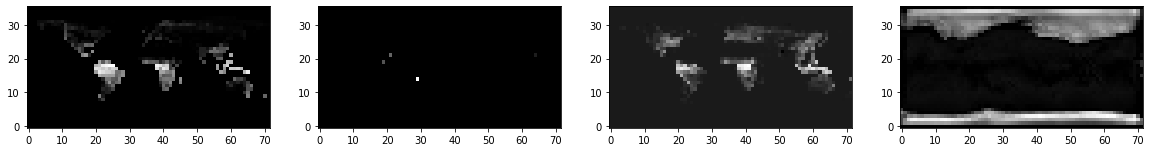


[0] - Finished evaluation - val_loss: 0.0709

[INFO] - Total time elapsed: 0.4850 min. Total time remaining: 120.7582 min.

[EPOCH] ____________________1____________________
[1] - Finished Epoch in 41.31 seconds - train_loss: 0.0146


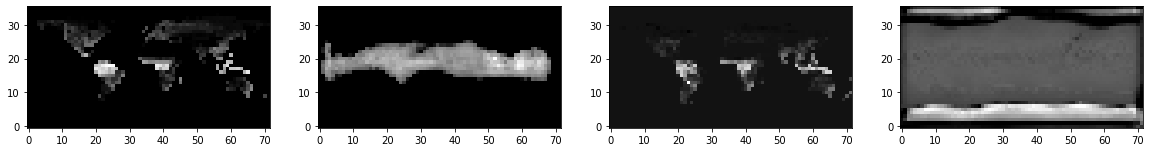


[1] - Finished evaluation - val_loss: 0.0603

[EPOCH] ____________________2____________________
[2] - Finished Epoch in 41.67 seconds - train_loss: 0.0100


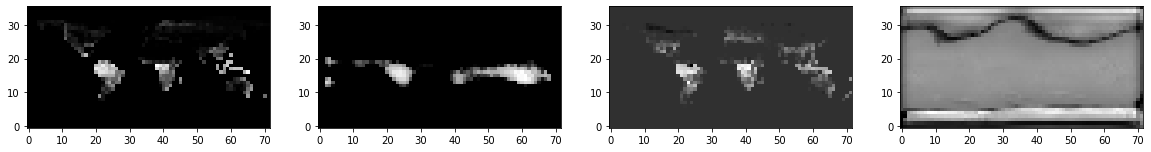


[2] - Finished evaluation - val_loss: 0.0447

[EPOCH] ____________________3____________________
[3] - Finished Epoch in 42.71 seconds - train_loss: 0.0093


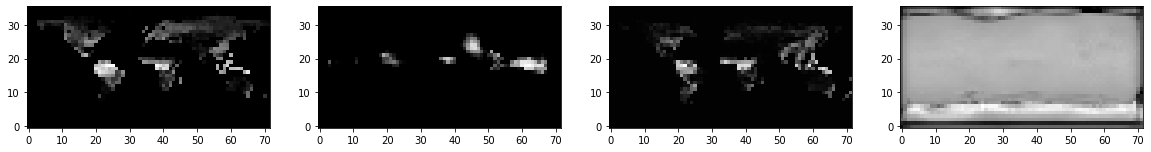


[3] - Finished evaluation - val_loss: 0.0333

[INFO] - Total time elapsed: 1.9757 min. Total time remaining: 121.5052 min.

[EPOCH] ____________________4____________________
[4] - Finished Epoch in 42.70 seconds - train_loss: 0.0091


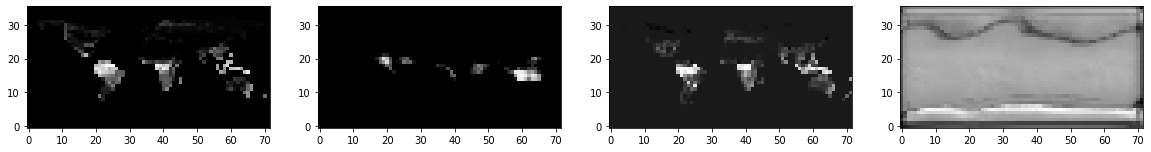


[4] - Finished evaluation - val_loss: 0.0239

[EPOCH] ____________________5____________________
[5] - Finished Epoch in 41.38 seconds - train_loss: 0.0087


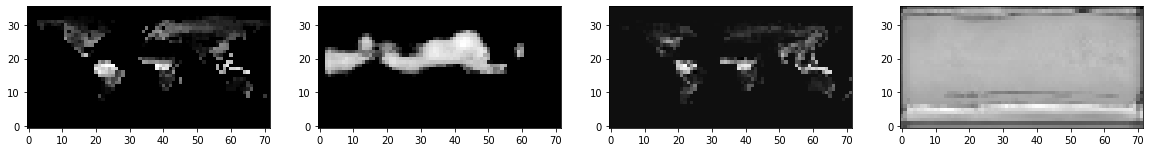


[5] - Finished evaluation - val_loss: 0.0180

[EPOCH] ____________________6____________________
[6] - Finished Epoch in 41.10 seconds - train_loss: 0.0084


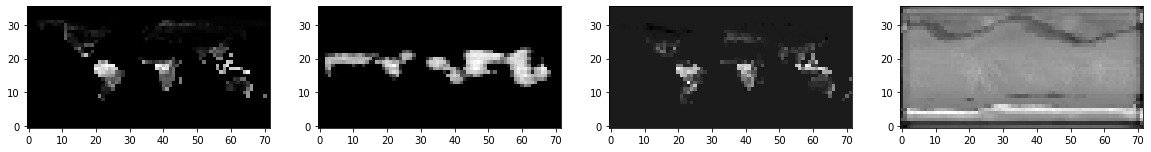


[6] - Finished evaluation - val_loss: 0.0148

[INFO] - Total time elapsed: 3.4654 min. Total time remaining: 120.2981 min.

[EPOCH] ____________________7____________________
[7] - Finished Epoch in 41.44 seconds - train_loss: 0.0080


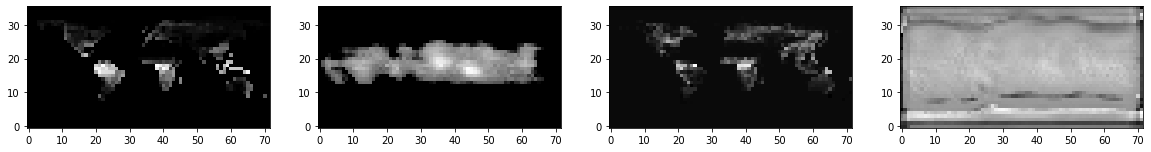


[7] - Finished evaluation - val_loss: 0.0121

[EPOCH] ____________________8____________________
[8] - Finished Epoch in 40.99 seconds - train_loss: 0.0079


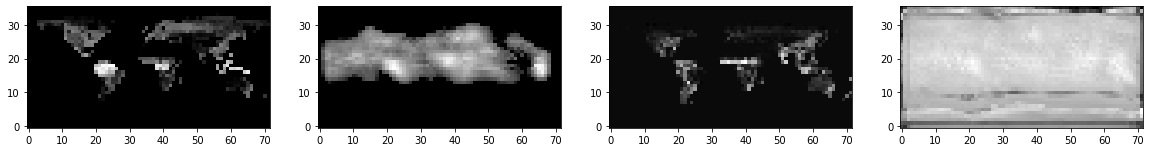


[8] - Finished evaluation - val_loss: 0.0108

[EPOCH] ____________________9____________________
[9] - Finished Epoch in 42.83 seconds - train_loss: 0.0075


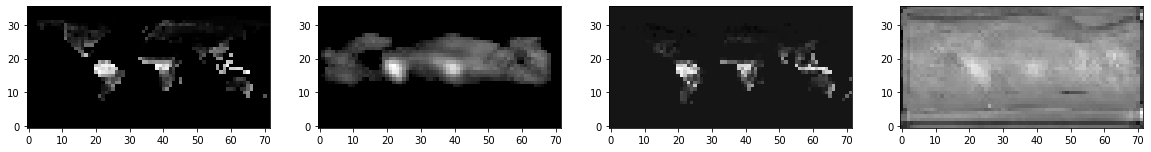


[9] - Finished evaluation - val_loss: 0.0095

[INFO] - Total time elapsed: 4.9664 min. Total time remaining: 119.1933 min.

[EPOCH] ____________________10____________________
[10] - Finished Epoch in 41.94 seconds - train_loss: 0.0071


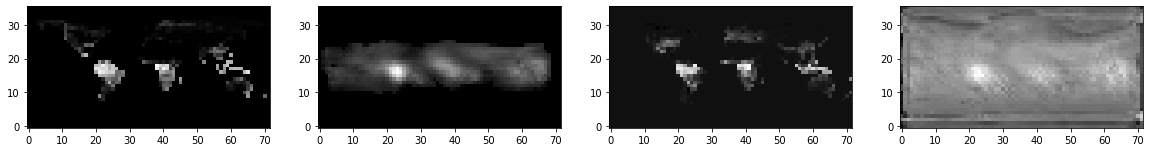


[10] - Finished evaluation - val_loss: 0.0084

[EPOCH] ____________________11____________________
[11] - Finished Epoch in 41.98 seconds - train_loss: 0.0070


KeyboardInterrupt: 

In [115]:
epochs = 250
for epoch in range(epochs):
    print(f'\n[EPOCH] ____________________{epoch}____________________')
    
    # training step with metrics update--------------------------------------------------------
    timer.start()

    train_step(model, train_ds, loss_function, optimizer, train_loss_metric, shape)

    # Evaluating training metrics
    train_loss = train_loss_metric.result()
    #train_acc = train_acc_metric.result()
    
    with train_summary_writer.as_default():     # logging our metrics to a file which is used by tensorboard
        tf.summary.scalar('loss', train_loss, step=epoch)
        #tf.summary.scalar('accuracy', train_acc, step=epoch)

    
    elapsed_time = timer.stop()
    
    print(f'[{epoch}] - Finished Epoch in {elapsed_time:0.2f} seconds - train_loss: {train_loss:0.4f}')
    
    # evaluation step with metrics update--------------------------------------------------------
    timer.start()

    eval_step(model, val_ds, loss_function, 
              loss_metric=val_loss_metric, 
             shape = shape)
    plt.show()
    # Evaluating validation metrics
    val_loss = val_loss_metric.result()
    #val_acc = val_acc_metric.result()
    
    with val_summary_writer.as_default():       # logging our metrics to a file which is used by tensorboard
        tf.summary.scalar('loss', val_loss, step=epoch)
        #tf.summary.scalar('accuracy', val_acc, step=epoch)
    
    print(f'\n[{epoch}] - Finished evaluation - val_loss: {val_loss:0.4f}')#, val_accuracy: {val_acc:0.4f}')
    
    # Resetting train and validation metrics-----------------------------------------------------
    #train_acc_metric.reset_states()
    #val_acc_metric.reset_states()
    train_loss_metric.reset_states()
    val_loss_metric.reset_states()
    
    elapsed_time = timer.stop()
    times.append(elapsed_time)
  
    if epoch%3 == 0:
        print(f'\n[INFO] - Total time elapsed: {np.sum(times)/60:0.4f} min. Total time remaining: {(np.sum(times)/(epoch+1))*(epochs-epoch-1)/60:0.4f} min.')

print(f'[INFO] - Total run time: {np.sum(times)/60:0.4f} min.')

In [45]:
for i,t in train_ds.take(1):
    a =model(i,training=False, shape = shape)

In [46]:
a = a.numpy()

In [64]:
np.median(a)

0.0002720684

In [56]:
t.numpy().min()

-2.1227619e-08

In [63]:
np.median(t.numpy())

0.0

In [24]:
tf.keras.backend.clear_session